<a href="https://colab.research.google.com/github/jese182/deeplearning_project/blob/main/GTZAN_music_classification/gtzan_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:05<00:00, 244MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

In [8]:
# glob는 파일 경로를 검색하는 데 사용하는 Python 표준 라이브러리

import glob
audio_dir = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data"

# 재귀적으로 모든 .wav 파일 탐색
audio_files = glob.glob(f"{audio_dir}/**/*.wav", recursive=True)
print(f"총 {len(audio_files)}개의 오디오 파일을 발견했습니다.")
# .wav 파일들의 파일 경로 리스트로 반환

총 1000개의 오디오 파일을 발견했습니다.


In [20]:
# 오디오 파일 경로 설정 (audio_files 리스트에서 첫 번째 파일 사용)
audio_path = audio_files[0]

# 오디오 파일 로드
y, sr = librosa.load(audio_path, sr=None)  # sr=None이면 원본 샘플링 레이트 유지

# 숫자 데이터 출력
print("오디오 숫자 데이터 (첫 10개 샘플):", y[:10])
print("샘플링 레이트:", sr)
print("오디오 데이터 길이 (샘플 개수):", len(y))

오디오 숫자 데이터 (첫 10개 샘플): [0.20800781 0.17477417 0.1178894  0.07669067 0.0625     0.0647583
 0.07366943 0.07632446 0.0859375  0.11703491]
샘플링 레이트: 22050
오디오 데이터 길이 (샘플 개수): 661794


In [12]:
# 데이터 경로 설정 (사용자의 실제 데이터 경로로 수정 필요)
data_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original"

# 장르 폴더 목록 확인
genres = os.listdir(data_path)
print(f"Available genres: {genres}")


Available genres: ['rock', 'jazz', 'classical', 'country', 'pop', 'hiphop', 'disco', 'blues', 'metal', 'reggae']


In [13]:
# 첫 번째 장르 폴더에서 샘플 오디오 파일 경로 설정
sample_genre = genres[0]  # 예: "blues"
sample_file = os.path.join(data_path, sample_genre, os.listdir(os.path.join(data_path, sample_genre))[0])
print(f"Sample file path: {sample_file}")
# 오디오 파일 로드
y, sr = librosa.load(sample_file, sr=None)  # 원본 샘플링 속도 유지
print(f"Sample Rate: {sr}")
print(f"Audio Length: {len(y)/sr:.2f} seconds")



Sample file path: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/rock/rock.00048.wav
Sample Rate: 22050
Audio Length: 30.01 seconds


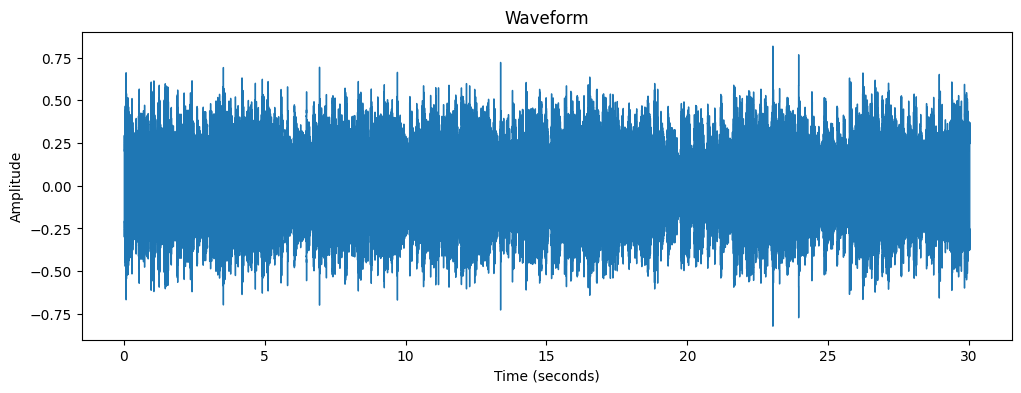

In [14]:
# 오디오 신호 시각화 (파형)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


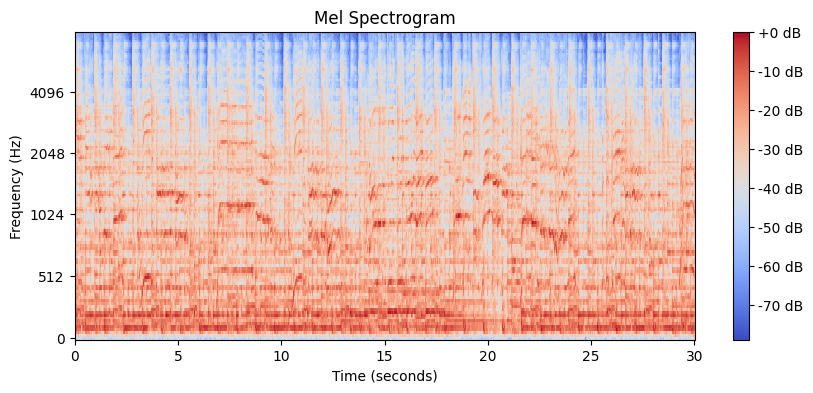

In [15]:
# Mel Spectrogram 변환
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)  # Mel-spectrogram 생성
S_dB = librosa.power_to_db(S, ref=np.max)  # 데시벨 단위로 변환
# Mel Spectrogram 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", fmax=8000, cmap="coolwarm")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()


In [18]:
# 파일 경로에서 장르 추출 및 데이터프레임 생성
def extract_genre_from_path(path):
    parts = path.split(os.sep)
    for part in parts:
        if part in ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']:
            return part
    return None

# 문제가 있는 파일을 제외하고 데이터프레임 생성
data = pd.DataFrame({
    'path': audio_files,
    'genre': [extract_genre_from_path(path) for path in audio_files]
})

# jazz.00054.wav 파일 제외
data = data[~data['path'].str.contains('jazz.00054.wav')]

print("최종 데이터셋 크기:", len(data))
print("\n장르별 데이터 분포:")
print(data['genre'].value_counts())

최종 데이터셋 크기: 999

장르별 데이터 분포:
genre
rock         100
classical    100
country      100
pop          100
hiphop       100
disco        100
blues        100
metal        100
reggae       100
jazz          99
Name: count, dtype: int64


  0%|          | 0/999 [00:00<?, ?it/s]

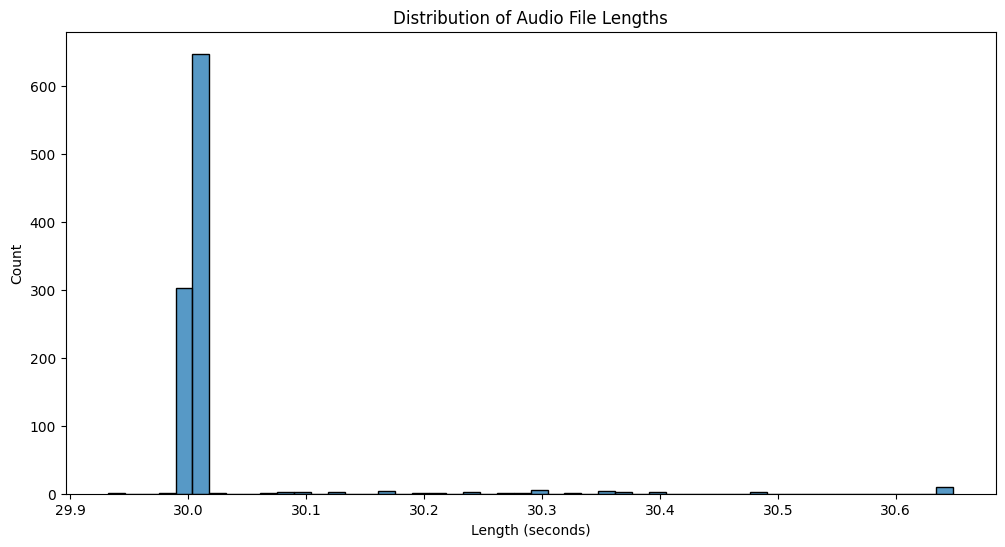

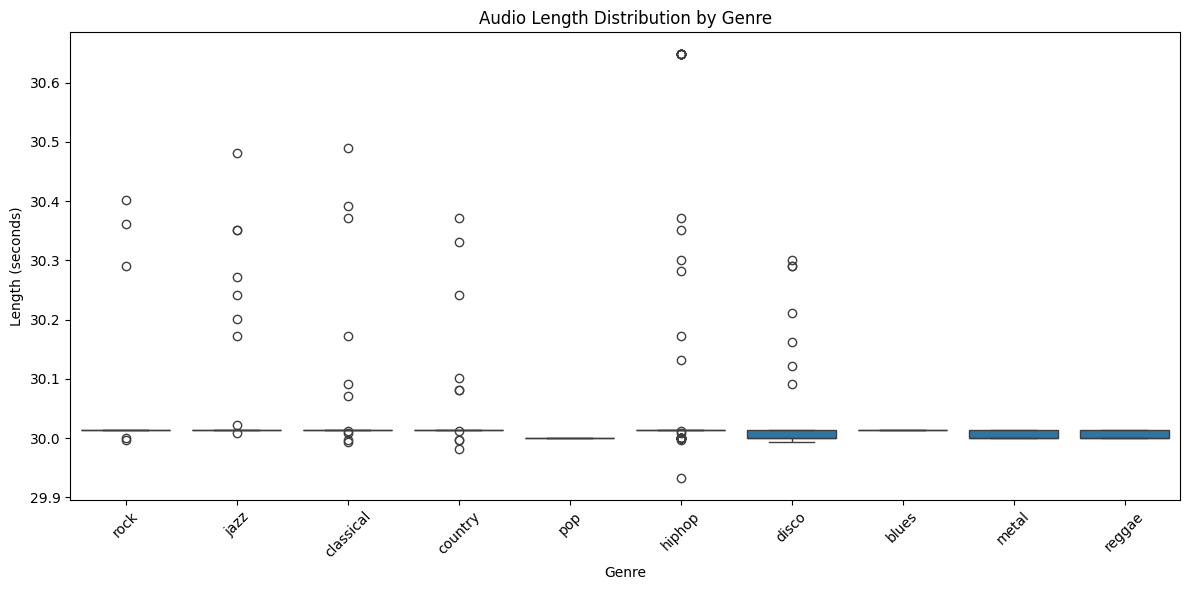


길이 통계:
count    999.000000
mean      30.024071
std        0.080951
min       29.931973
25%       30.000181
50%       30.013333
75%       30.013333
max       30.648889
Name: length, dtype: float64

장르별 평균 길이:
genre
hiphop       30.089263
jazz         30.033311
classical    30.027941
country      30.023935
rock         30.023156
disco        30.019719
blues        30.013333
reggae       30.005574
metal        30.004390
pop          30.000181
Name: length, dtype: float64


In [19]:


# 모든 오디오 파일의 길이를 추출하는 함수
def get_audio_lengths(df):
    lengths = []
    for file_path in tqdm(df['path']):
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        lengths.append(duration)
    return lengths

# 길이 데이터 추출
data['length'] = get_audio_lengths(data)

# 전체 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='length', bins=50)
plt.title('Distribution of Audio File Lengths')
plt.xlabel('Length (seconds)')
plt.ylabel('Count')
plt.show()

# 장르별 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='genre', y='length')
plt.title('Audio Length Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Length (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 기본 통계량 출력
print("\n길이 통계:")
print(data['length'].describe())

# 장르별 평균 길이
print("\n장르별 평균 길이:")
print(data.groupby('genre')['length'].mean().sort_values(ascending=False))

In [ ]:
def load_and_process_audio(file_path, sr=22050, duration=30):
     #  Mel Spectrogram의 크기가 일정하지 않으면 에러발생. 모든 오디오 샘플의 길이를 동일하게 맞춰줘야함.
    """
    오디오 파일을 로드하고 고정된 크기의 Mel Spectrogram으로 변환하는 함수
    """
    try:
        # 오디오 파일 로드 (모노로 변환), 정확히 30초로 고정
        # 샘플링 레이트(sr)와 신호 데이터(signal)를 반환
        # sr=22050: 샘플링 레이트를 22,050 Hz로 설정.
        # duration=30: 최대 30초 길이로 읽음. 파일이 더 길면 앞부분만 가져옴
        signal, sr = librosa.load(file_path, sr=sr, duration=duration)

        # signal이 30초보다 짧은 경우 패딩
        if len(signal) < sr * duration:
            signal = np.pad(signal, (0, sr * duration - len(signal)))


        # 오디오 신호 고정만으로 Mel Spectrogram의 모든 배열 크기가 항상 동일하다고 보장할 수 없음
        # 데이터의 일관성 및 예외 상황에 대비하기 위해 둘 다 고정하는 것이 일반적

        # Mel Spectrogram 생성 (고정된 크기로)
        mel_spec = librosa.feature.melspectrogram(
            y=signal,
            sr=sr,
            n_mels=128, # 주파수 축의 크기(몇개의 주파수로 나눌것인지? 이 값이 클수록 더 세밀한 주파수 정보를 제공)
            n_fft=2048, # 푸리에 변환 윈도우 크기(샘플 개수)
            hop_length=512, # 프레임 간 이동 간격
            win_length=2048 #실제로 분석할 오디오 신호의 길이

        )

        # 파워 스펙트로그램을 데시벨 스케일로 변환(log스케일)
        # 인간의 귀는 소리를 선형적으로 인식하지 않고, 로그 스케일로 인식

        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # 고정된 크기로 조정 (시간 축을 130으로 고정)
        # shape[1]이 130보다 크면 자르고, 작으면 패딩(0으로 채움)
        fixed_length = 130  # 약 30초에 해당하는 프레임 수
        if mel_spec_db.shape[1] > fixed_length:
            mel_spec_db = mel_spec_db[:, :fixed_length]
        else:
            pad_width = fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0,0), (0,pad_width)), mode='constant')

        return mel_spec_db #출력: (128, 130) 크기의 멜 스펙트로그램


    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

In [ ]:
def apply_augmentation(mel_spec):
    """
    Mel Spectrogram에 데이터 증강을 적용하는 함수

    매개변수:
    - mel_spec: 원본 Mel Spectrogram

    반환값:
    - 증강된 Mel Spectrogram
    """
    # 주파수 마스킹 함수 (스펙트로그램의 행(주파수) 범위 f0부터 f0+f까지 포함된 모든 열(시간)을 대상으로 마스킹)
    def freq_mask(spec, F=30, num_masks=1):
        spec = spec.copy()  # 원본 데이터 보존을 위한 복사
        for i in range(num_masks):
            f = np.random.randint(0, F)  # 마스크 크기 랜덤 선택
            f0 = np.random.randint(0, spec.shape[0] - f)  # 마스크 시작 위치 랜덤 선택
            spec[f0:f0 + f, :] = spec.mean()  # 해당 주파수 범위의 값을 평균값으로 대체
        return spec

    # 시간 마스킹 함수 (스펙트로그램의 열(시간) 범위 t0부터 t0+t까지 포함된 모든 행(주파수)을 대상으로 마스킹)
    def time_mask(spec, T=40, num_masks=1):
        spec = spec.copy()  # 원본 데이터 보존을 위한 복사
        for i in range(num_masks):
            t = np.random.randint(0, T)  # 마스크 크기 랜덤 선택
            t0 = np.random.randint(0, spec.shape[1] - t)  # 마스크 시작 위치 랜덤 선택
            spec[:, t0:t0 + t] = spec.mean()  # 해당 시간 범위의 값을 평균값으로 대체
        return spec

    # 랜덤하게 증강 기법 선택 및 적용
    aug_type = np.random.randint(0, 3)
    if aug_type == 0:
        return freq_mask(mel_spec)  # 주파수 마스킹만 적용
    elif aug_type == 1:
        return time_mask(mel_spec)  # 시간 마스킹만 적용
    else:
        return freq_mask(time_mask(mel_spec))  # 둘 다 적용



In [ ]:


def prepare_dataset(audio_dir):
    """
    데이터셋을 준비하는 함수
    """
    X = []  # Mel Spectrogram을 저장할 리스트
    y = []  # 장르 레이블을 저장할 리스트

    # 모든 장르 폴더 가져오기
    genre_folders = glob.glob(os.path.join(audio_dir, "genres_original/*"))

    # 각 장르별로 처리
    for genre_path in genre_folders:
        genre = os.path.basename(genre_path)  # 장르명 추출
        print(f"Processing {genre}...")

        # 현재 장르의 모든 .wav 파일 처리
        audio_files = glob.glob(os.path.join(genre_path, "*.wav"))
        for audio_file in audio_files:
            # 문제가 있는 파일 건너뛰기
            if "jazz.00054.wav" in audio_file:
                print(f"Skipping problematic file: {audio_file}")
                continue

            mel_spec = load_and_process_audio(audio_file)
            if mel_spec is not None and mel_spec.shape == (128, 130):  # 크기 확인
                X.append(mel_spec)
                y.append(genre)
            else:
                print(f"Skipping {audio_file} due to incorrect shape")

    print(f"\n총 처리된 파일 수: {len(X)}")

    # numpy 배열로 변환
    X = np.array(X)
    y = np.array(y)

    # 레이블 인코딩 (장르명을 숫자로 변환)
    le = LabelEncoder()
    y = le.fit_transform(y)

    # 1. 전체 데이터를 train+validation과 test로 분할 (85:15)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=0.15,
        random_state=42,
        stratify=y
    )

    # 2. train+validation 데이터에 대해 증강 수행
    X_aug = []
    y_aug = []

    for i in range(len(X_temp)):
        # 원본 데이터 추가
        X_aug.append(X_temp[i])
        y_aug.append(y_temp[i])
        # 증강 데이터 추가
        aug_spec = apply_augmentation(X_temp[i])
        X_aug.append(aug_spec)
        y_aug.append(y_temp[i])

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    # 3. 증강된 train+validation 데이터를 train과 validation으로 분할 (80:20)
    X_train, X_val, y_train, y_val = train_test_split(
        X_aug, y_aug,
        test_size=0.2,
        random_state=42,
        stratify=y_aug
    )

    print("\n최종 데이터셋 크기:")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test, le.classes_

# 데이터셋 준비 시작
audio_dir = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data"
X_train, X_val, X_test, y_train, y_val, y_test, class_names = prepare_dataset(audio_dir)

Processing blues...
Processing metal...
Processing classical...
Processing country...
Processing rock...
Processing hiphop...
Processing reggae...
Processing pop...
Processing jazz...
Skipping problematic file: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav
Processing disco...

총 처리된 파일 수: 999

최종 데이터셋 크기:
Training set: (1358, 128, 130)
Validation set: (340, 128, 130)
Test set: (150, 128, 130)


In [ ]:
X_train.shape

(1358, 128, 130)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 130, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 130, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 65, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 65, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,186 (508.54 KB)

 Trainable params: 129,226 (504.79 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.2140 - loss: 2.5107 - val_accuracy: 0.2000 - val_loss: 2.5136 - learning_rate: 0.0010
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2806 - loss: 2.1269 - val_accuracy: 0.2382 - val_loss: 2.0930 - learning_rate: 0.0010
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3269 - loss: 2.0483 - val_accuracy: 0.2941 - val_loss: 2.0579 - learning_rate: 0.0010
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3892 - loss: 1.7469 - val_accuracy: 0.1059 - val_loss: 6.7366 - learning_rate: 0.0010
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4232 - loss: 1.6621 - val_accuracy: 0.2618 - val_loss: 2.9218 - learning_rate: 0.0010
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5055 - loss: 1.4374 - val_accuracy: 0.2824 - val_loss: 1.8941 - learning_rate: 0.0010
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5521 - loss: 1.3377 - val_ac

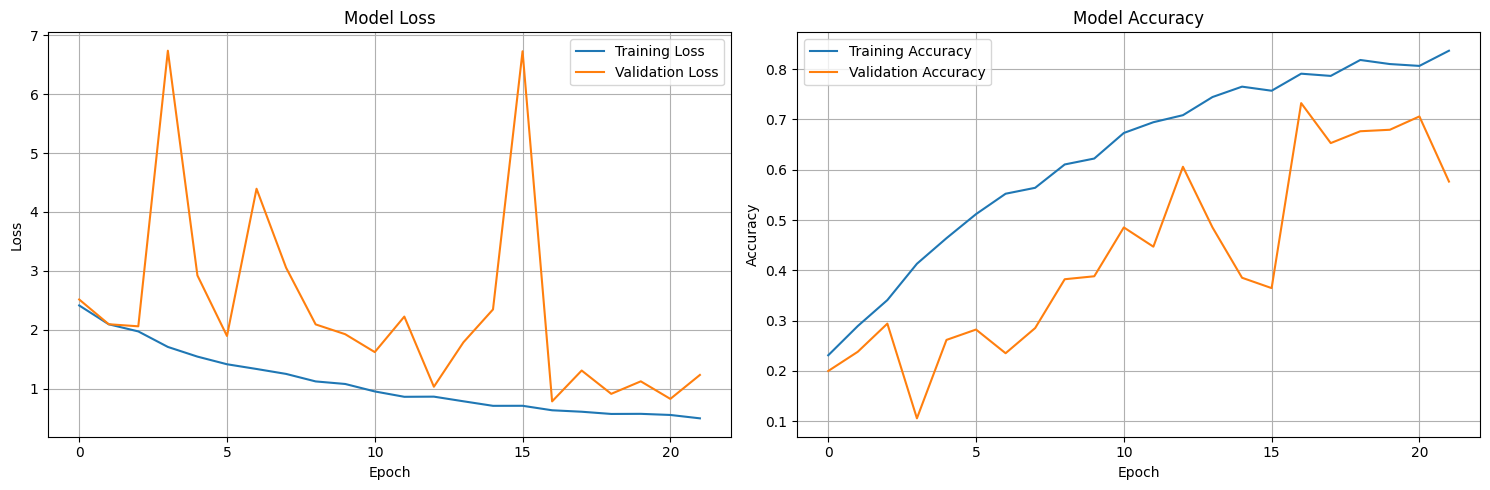


최종 학습 결과:
Training Accuracy: 0.8365
Validation Accuracy: 0.7324

Test Accuracy: 0.6467


In [ ]:
def create_model():
    input_shape = (128, 130, 1)
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),

        # Convolution 블록 수를 4개에서 3개로 줄임
        # 첫 번째 블록
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),  # 드롭아웃 비율 증가

        # 두 번째 블록
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # 세 번째 블록
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.GlobalAveragePooling2D(),

        # Dense 층의 뉴런 수를 줄임
        layers.Dense(256, activation='relu'),  # 512 -> 256
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(10, activation='softmax')
    ])

    # L2 정규화를 추가한 옵티마이저 사용
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001,
            weight_decay=0.0001  # L2 정규화 추가
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 데이터 reshape (채널 차원 추가)
X_train = X_train.reshape(-1, 128, 130, 1)
X_val = X_val.reshape(-1, 128, 130, 1)
X_test = X_test.reshape(-1, 128, 130, 1)

# 모델 생성
model = create_model()

# 모델 구조 출력
model.summary()


# # 배치 사이즈를 더 작게 조정
# batch_size = 16  # 32 -> 16

# 콜백 함수의 patience를 줄임
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  # 10 -> 5
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    ),
    # 학습률 감소 추가
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001
    )
]

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# 학습 과정 시각화
def plot_training_history(history):
    """
    모델의 학습 과정을 시각화하는 함수
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 손실 그래프
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 정확도 그래프
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # 최종 결과 출력
    print("\n최종 학습 결과:")
    print(f"Training Accuracy: {max(history.history['accuracy']):.4f}")
    print(f"Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

# 학습 과정 시각화 실행
plot_training_history(history)

# 테스트 세트에 대한 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.6467
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


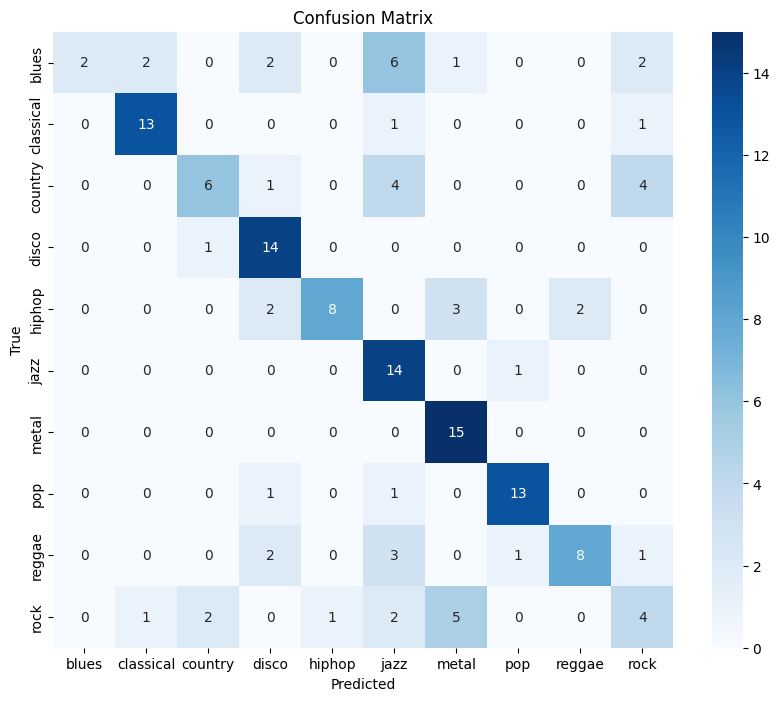

In [ ]:
# 테스트 세트에 대한 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# 혼돈 행렬을 위한 예측값 생성
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측 확률 중 가장 높은 클래스 선택

# 혼돈 행렬 생성
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)

# 혼돈 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# 혼돈 행렬에서 각 라벨별 정확도 계산
accuracies = {}
for i in range(len(class_names)):
    # 해당 클래스의 총 샘플 수
    total = np.sum(cm[i])
    # 정확히 분류된 샘플 수
    correct = cm[i,i]
    # 정확도 계산
    accuracy = correct / total
    accuracies[class_names[i]] = accuracy

# 정확도를 기준으로 내림차순 정렬
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda x: x[1], reverse=True))


# 결과 출력
print("\n각 장르별 정확도 (내림차순):")
for genre, acc in sorted_accuracies.items():
    print(f"{genre:10s}: {acc:.4f} ({int(cm[list(class_names).index(genre),list(class_names).index(genre)])}/{np.sum(cm[list(class_names).index(genre)])})")